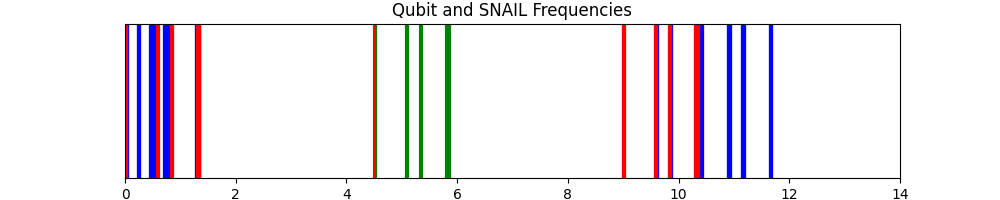

In [1]:
import matplotlib.pyplot as plt
from ipywidgets import interactive_output, VBox, HBox, FloatSlider, Layout
import numpy as np

%matplotlib widget

# Create a figure and axes for plotting
fig, ax = plt.subplots(figsize=(10, 2))

# Number of qubits can be adjusted here
num_qubits = 5

# Create sliders for qubits and SNAIL
sliders = {
    f"qubit_{i}": FloatSlider(
        value=np.random.uniform(3, 6),
        min=0,
        max=6,
        description=f"Qubit {i}",
        # orientation="vertical",
        continuous_update=False,
        step=0.01,
    )
    for i in range(num_qubits)
}
sliders["snail"] = FloatSlider(
    value=4.5,
    min=3,
    max=7,
    description="SNAIL",
    # orientation="vertical",
    continuous_update=False,
    step=0.01,
)


# initialize the dictionary
initial_frequencies = np.linspace(3, 7, num_qubits + 1)  # +1 for SNAIL
frequency_dict = {}
for qubit in range(num_qubits):
    frequency_dict[f"qubit_{qubit}"] = ax.axvline(
        initial_frequencies[qubit], color="green", linestyle="-", linewidth=3
    )
frequency_dict["snail"] = ax.axvline(
    initial_frequencies[-1], color="red", linestyle="-", linewidth=2
)

# add frequency pairs to the dictionary (sum and difference)
# use frozenset() to ensure that the order of the keys doesn't matter
for i, mode1 in enumerate(initial_frequencies):
    for j, mode2 in enumerate(initial_frequencies):
        if i == j:
            continue
        key1 = f"qubit_{i}"
        key2 = f"qubit_{j}"
        if i == len(initial_frequencies) - 1:
            key1 = "snail"
        if j == len(initial_frequencies) - 1:
            key2 = "snail"

        freq1 = initial_frequencies[i]
        freq2 = initial_frequencies[j]

        sum_freq = freq1 + freq2
        diff_freq = abs(freq1 - freq2)
        sum_key = f"sum_{key1}_{key2}"
        diff_key = f"diff_{key1}_{key2}"
        # frequency_dict[sum_key] = sum_freq
        # frequency_dict[diff_key] = diff_freq

        alpha = 1
        if "snail" in sum_key:
            color = "red"
            # transparenet
            # alpha = 0
        else:
            color = "blue"

        frequency_dict[sum_key] = ax.axvline(
            sum_freq, color=color, linestyle="-", linewidth=3, alpha=alpha
        )
        frequency_dict[diff_key] = ax.axvline(
            diff_freq, color=color, linestyle="-", linewidth=3, alpha=alpha
        )

# Initialize plot properties
ax.set_xlim(0, 14)
ax.get_yaxis().set_visible(False)
plt.title("Qubit and SNAIL Frequencies")


# Function to update the plot
def update_plot(**mode_frequencies):
    # Update the frequency lines
    for mode, freq in mode_frequencies.items():
        frequency_dict[mode].set_xdata([freq, freq])

    # update the pairs
    for key1, freq1 in mode_frequencies.items():
        for key2, freq2 in mode_frequencies.items():
            if key1 == key2:
                continue
            sum_freq = freq1 + freq2
            diff_freq = abs(freq1 - freq2)
            sum_key = f"sum_{key1}_{key2}"
            diff_key = f"diff_{key1}_{key2}"
            frequency_dict[sum_key].set_xdata([sum_freq, sum_freq])
            frequency_dict[diff_key].set_xdata([diff_freq, diff_freq])

    # Redraw the figure to update the lines
    fig.canvas.draw_idle()


# Layout adjustments for better UI
slider_layout = VBox(list(sliders.values()), layout=Layout(width="400"))
plot_layout = interactive_output(update_plot, sliders)

# Display the interactive widgets alongside the plot
display(HBox([slider_layout, plot_layout]))

In [2]:
import numpy as np
import numpy as np


class FrequencyOptimizer:
    def __init__(self, allowed_range=(4.0, 6.0), num_qubits=2):
        self.allowed_range = allowed_range
        # Initialize with minimum and maximum frequencies for the first two qubits,
        # adhering to the requirement to start with bare frequencies at the edges of the allowed range.
        self.bare_frequencies = [allowed_range[0], allowed_range[1]]
        # Lists to store interaction frequencies. Interaction frequencies are calculated
        # each time a new frequency is added to the system, as per requirements.
        self.qubit_qubit_interactions = []
        self.qubit_snail_interactions = []
        # Adjust the number of qubits as specified by the user.
        self.num_qubits = num_qubits
        # Initialize interaction frequencies for the first two qubits.
        self._initialize_interaction_frequencies()

        # Add qubits to meet the specified number of qubits, following the greedy optimization approach.
        while len(self.bare_frequencies) < self.num_qubits:
            self._add_new_qubit()
        # Once all qubits are placed, add the SNAIL frequency.
        self._add_snail()

    def _initialize_interaction_frequencies(self):
        # Calculate and update interactions for the initial qubits.
        self._calculate_and_update_interactions(
            self.bare_frequencies[0], self.bare_frequencies[1]
        )

    def _calculate_and_update_interactions(self, freq1, freq2, is_snail=False):
        # Calculate qubit-qubit and, conditionally, qubit-SNAIL interaction frequencies.
        self.qubit_qubit_interactions.extend([freq1 + freq2, abs(freq1 - freq2)])
        if is_snail:
            # Qubit-SNAIL interactions follow the same calculation but are tracked separately.
            self.qubit_snail_interactions.extend([freq1 + freq2, abs(freq1 - freq2)])

    def _calculate_potential_interactions(self, new_freq):
        # Calculate potential new qubit-qubit interactions for the new frequency with all existing qubits.
        return [new_freq + f for f in self.bare_frequencies] + [
            abs(new_freq - f) for f in self.bare_frequencies
        ]

    def _evaluate_new_frequency(self, new_freq, include_snail=False):
        # Evaluate a new frequency by considering its impact on qubit-qubit interaction terms.
        potential_interactions = self._calculate_potential_interactions(new_freq)
        # Include potential new interactions in the evaluation to assess how crowded these terms are.
        all_frequencies = (
            self.bare_frequencies
            + self.qubit_qubit_interactions
            + potential_interactions
        )
        if include_snail:
            # When evaluating for the SNAIL, consider its interactions with qubits too.
            all_frequencies += self._calculate_potential_interactions(new_freq)

        # Calculate nearest neighbor distances for each potential qubit-qubit interaction term.
        distances = [
            min([abs(inter_freq - freq) for freq in all_frequencies])
            for inter_freq in potential_interactions
        ]
        # Focus on optimizing these distances to minimize interference.
        min_distance = min(distances)
        avg_distance = sum(distances) / len(distances) if distances else 0

        return min_distance, avg_distance

    def _find_optimal_frequency(self, include_snail=False):
        # Greedy optimization to find the frequency that maximizes the minimum nearest neighbor distance.
        optimal_freq = None
        best_score = (
            -np.inf,
            -np.inf,
        )  # Initialize with impossible values for comparison.
        for freq in np.linspace(*self.allowed_range, 1000):
            score = self._evaluate_new_frequency(freq, include_snail=include_snail)
            # Apply tie-breaking strategy: first by min_distance, then by avg_distance.
            if score > best_score:
                optimal_freq = freq
                best_score = score

        return optimal_freq

    def _add_new_qubit(self):
        # Add a new qubit by finding an optimal frequency for it.
        new_freq = self._find_optimal_frequency()
        self.bare_frequencies.append(new_freq)
        # Update interaction frequencies with the new qubit frequency.
        for freq in self.bare_frequencies[:-1]:  # Exclude the new frequency itself.
            self._calculate_and_update_interactions(new_freq, freq)

    def _add_snail(self):
        # Add the SNAIL frequency, ensuring it doesn't overlap with qubit-qubit interactions or bare frequencies.
        snail_freq = self._find_optimal_frequency(include_snail=True)
        self.bare_frequencies.append(snail_freq)
        # Update qubit-SNAIL interactions with the new SNAIL frequency.
        for qubit_freq in self.bare_frequencies[
            :-1
        ]:  # Exclude the SNAIL frequency itself.
            self._calculate_and_update_interactions(
                qubit_freq, snail_freq, is_snail=True
            )


# Example usage
optimizer = FrequencyOptimizer(num_qubits=3)  # Adjust num_qubits as needed
print("Optimized Bare Frequencies:", optimizer.bare_frequencies)
print("Qubit-Qubit Interactions:", optimizer.qubit_qubit_interactions)
print("Qubit-SNAIL Interactions:", optimizer.qubit_snail_interactions)

Optimized Bare Frequencies: [4.0, 6.0, 4.0, 4.0]
Qubit-Qubit Interactions: [10.0, 2.0, 8.0, 0.0, 10.0, 2.0, 8.0, 0.0, 10.0, 2.0, 8.0, 0.0]
Qubit-SNAIL Interactions: [8.0, 0.0, 10.0, 2.0, 8.0, 0.0]


In [21]:
import numpy as np
from tqdm import tqdm


class FrequencyAllocator:
    def __init__(self, qubit_min=4.0, qubit_max=6.0, num_qubits=2):
        self.qubit_min = qubit_min
        self.qubit_max = qubit_max
        self.num_qubits = num_qubits
        self.qubit_qubit_interactions = []
        self.qubit_snail_interactions = []
        self.bare_frequencies = [qubit_min, qubit_max]
        self.snail = None
        self.min_spacing = float("inf")
        self.avg_spacing = float("inf")
        self._update_interactions()

        while len(self.bare_frequencies) < self.num_qubits:
            self.add_qubit()
        self.add_snail()

    def _update_interactions(self):
        # Reset and calculate qubit-qubit interactions.
        self.qubit_qubit_interactions = []
        for i, freq1 in enumerate(self.bare_frequencies):
            for freq2 in self.bare_frequencies[i + 1 :]:
                self.qubit_qubit_interactions.extend(
                    [freq1 + freq2, abs(freq1 - freq2)]
                )

    def _add_snail_interactions(self):
        # Directly calculate and update interactions for the SNAIL with all qubits.
        if self.snail is not None:
            self.qubit_snail_interactions = [
                freq + self.snail for freq in self.bare_frequencies
            ] + [abs(freq - self.snail) for freq in self.bare_frequencies]

    def _potential_interactions(self, new_freq):
        # Ensure SNAIL is added last as per requirements.
        assert self.snail is None, "SNAIL should be added last."
        # Calculate potential interactions for a new qubit frequency.
        return [new_freq + freq for freq in self.bare_frequencies] + [
            abs(new_freq - freq) for freq in self.bare_frequencies
        ]

    def _evaluate_new_frequency(self, new_freq, is_snail=False):
        potential_interactions = self._potential_interactions(new_freq)

        # Construct the list of all interactions, always including the new frequency and potential interactions.
        all_interactions = (
            self.bare_frequencies
            + [new_freq]  # Include the new frequency for consideration.
            + self.qubit_qubit_interactions
            + potential_interactions  # Include potential new interactions.
            + self.qubit_snail_interactions  # SNAIL interactions are always considered.
        )

        # Check for duplicates to handle the case where the new frequency exactly matches an existing frequency.
        if len(all_interactions) != len(set(all_interactions)):
            return 0, 0  # Return the worst score for duplicates, as specified.

        # Sort all interactions to optimize nearest neighbor search.
        all_interactions_sorted = sorted(all_interactions)

        distances = []
        # Prepare the list of frequencies to evaluate based on whether we're adding a SNAIL or not.
        candidate_interactions = self.qubit_qubit_interactions + (
            potential_interactions if not is_snail else []
        )

        for base_freq in candidate_interactions:
            # Find the position of base_freq in the sorted list to efficiently find its nearest neighbors.
            pos = all_interactions_sorted.index(base_freq)
            # Calculate distances to the nearest neighbors in the sorted list.
            if pos > 0:
                left_distance = abs(base_freq - all_interactions_sorted[pos - 1])
            else:
                left_distance = float("inf")

            if pos < len(all_interactions_sorted) - 1:
                right_distance = abs(base_freq - all_interactions_sorted[pos + 1])
            else:
                right_distance = float("inf")

            # The nearest neighbor distance is the minimum of the left and right distances.
            nearest_neighbor_distance = min(left_distance, right_distance)
            distances.append(nearest_neighbor_distance)

        # Calculate and return the minimum and average of the nearest neighbor distances.
        # if distances:
        return min(distances), sum(distances) / len(distances)

    def _find_optimal_frequency(self, is_snail=False):
        optimal_freq = None
        best_min_distance = -np.inf
        best_avg_distance = -np.inf
        for freq in np.linspace(self.qubit_min, self.qubit_max, 1800):
            min_distance, avg_distance = self._evaluate_new_frequency(
                freq, is_snail=is_snail
            )

            # Check if the new score is better based on min distance and then avg distance for tie-breaking.
            if min_distance > best_min_distance or (
                min_distance == best_min_distance and avg_distance > best_avg_distance
            ):
                best_min_distance = min_distance
                best_avg_distance = avg_distance
                optimal_freq = freq

        # Update class attributes with the current costs.
        self.min_spacing, self.avg_spacing = best_min_distance, best_avg_distance

        return optimal_freq

    def add_qubit(self):
        # Add a new qubit with an optimal frequency and update interactions accordingly.
        new_freq = self._find_optimal_frequency(is_snail=False)
        self.bare_frequencies.append(new_freq)
        self._update_interactions()

    def add_snail(self):
        # Ensure SNAIL tie-breaking logic is correctly handled.
        self.snail = self._find_optimal_frequency(is_snail=True)
        self._add_snail_interactions()

    def __str__(self):
        return f"Optimized Bare Frequencies: {self.bare_frequencies}\nOptimized SNAIL Frequency: {self.snail}\nMin Spacing: {self.min_spacing}\nAvg Spacing: {self.avg_spacing}"

    def _plot(self):
        # Plot the optimized frequencies and interactions.
        fig, ax = plt.subplots(figsize=(10, 2))
        ax.set_xlim(0, 14)
        ax.get_yaxis().set_visible(False)
        plt.title("Qubit and SNAIL Frequencies")

        # Plot the bare frequencies.
        for freq in self.bare_frequencies:
            ax.axvline(freq, color="green", linestyle="-", linewidth=3)

        # Plot the SNAIL frequency.
        ax.axvline(self.snail, color="red", linestyle="-", linewidth=2)

        # Plot the interaction frequencies.
        for freq in self.qubit_qubit_interactions:
            ax.axvline(freq, color="blue", linestyle="-", linewidth=3, alpha=0.5)

        for freq in self.qubit_snail_interactions:
            ax.axvline(freq, color="purple", linestyle="-", linewidth=3, alpha=0.5)

        plt.show()


# Example usage
allocator = FrequencyAllocator(num_qubits=4)  # Adjust the number of qubits as needed.
print(allocator)

Optimized Bare Frequencies: [4.0, 6.0, 4.665925514174542, 5.667593107281823]
Optimized SNAIL Frequency: 4.832684824902723
Min Spacing: 0.16564758198999563
Avg Spacing: 0.26375764313507527


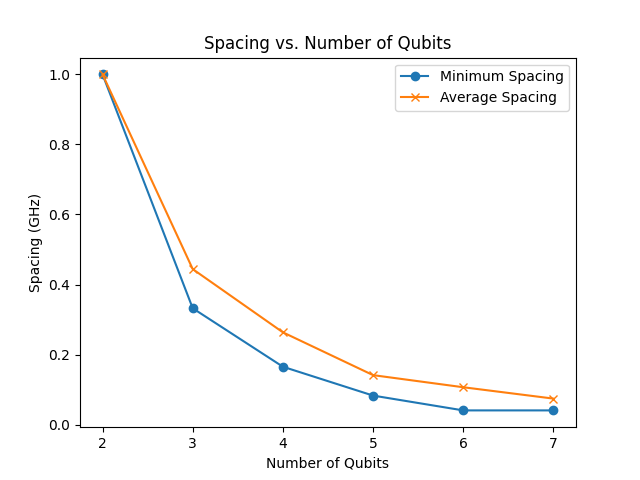

In [8]:
# plot min_spacing and avg_spacing as a function of num_qubits
min_spacings = []
avg_spacings = []
num_qubits = list(range(2, 8))
for n in num_qubits:
    allocator = FrequencyAllocator(num_qubits=n)
    min_spacings.append(allocator.min_spacing)
    avg_spacings.append(allocator.avg_spacing)

fig, ax = plt.subplots()
ax.plot(num_qubits, min_spacings, label="Minimum Spacing", marker="o")
ax.plot(num_qubits, avg_spacings, label="Average Spacing", marker="x")
ax.set_xlabel("Number of Qubits")
ax.set_ylabel("Spacing (GHz)")
ax.set_title("Spacing vs. Number of Qubits")
ax.legend()
plt.show()

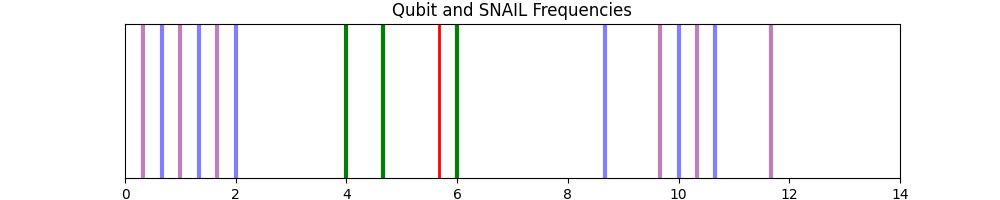

In [22]:
allocator = FrequencyAllocator(num_qubits=3)
allocator._plot()

In [18]:
allocator = FrequencyAllocator(num_qubits=3)
for gate in sorted(allocator.qubit_qubit_interactions):
    # print gate frequency as well as its spacing to its nearest neighbors
    # calcualte cost based on gate frequency's distance to its nearest neighbor out of the set of all other existing frequencies
    all_frequencies = (
        allocator.bare_frequencies
        + [allocator.snail]
        + allocator.qubit_qubit_interactions
        + allocator.qubit_snail_interactions
    )
    min_distance = min([abs(gate - freq) for freq in all_frequencies if gate != freq])
    print(f"Gate at {gate} GHz")
    print(f"Separated by {min_distance} GHz")

Gate at 0.6659255141745417 GHz
Separated by 0.33351862145636435 GHz
Gate at 1.3340744858254583 GHz
Separated by 0.33240689271817736 GHz
Gate at 2.0 GHz
Separated by 0.33240689271817736 GHz
Gate at 8.665925514174543 GHz
Separated by 1.00166759310728 GHz
Gate at 10.0 GHz
Separated by 0.33240689271817736 GHz
Gate at 10.665925514174543 GHz
Separated by 0.33240689271817914 GHz
